# MNIST softmax with `tf.summary`

* MNIST data를 가지고 softmax classifier를 만들어보자.
  * [참고 소스: mnist_softmax.py in verion 1.4](https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/examples/tutorials/mnist/mnist_softmax.py)
  * `tf.summary`를 이용하여 트레이닝 상황을 모니터링해보자.

## Import modules

In [1]:
"""A very simple MNIST classifier.
See extensive documentation at
https://www.tensorflow.org/get_started/mnist/beginners in version 1.4
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tensorflow as tf

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/lab4all/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Import data

In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data / 255.
train_data = train_data.reshape(-1, 784)
train_labels = np.asarray(train_labels, dtype=np.int32)

test_data = test_data / 255.
test_data = test_data.reshape(-1, 784)
test_labels = np.asarray(test_labels, dtype=np.int32)

### Show the MNIST

label = 3


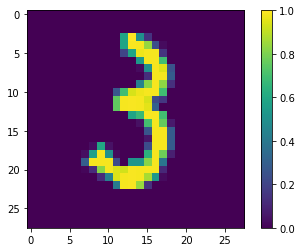

In [3]:
index = 1234
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index].reshape(28, 28))
plt.colorbar()
#plt.gca().grid(False)
plt.show()

### Set up dataset with `tf.data`

#### input pipeline `tf.data.Dataset` and Transformation

In [4]:
tf.set_random_seed(219)
batch_size = 32
max_epochs = 1

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size = 10000)
train_dataset = train_dataset.repeat(count = max_epochs)
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.batch(batch_size = len(test_data))
print(test_dataset)

<BatchDataset shapes: ((?, 784), (?,)), types: (tf.float64, tf.int32)>
<BatchDataset shapes: ((?, 784), (?,)), types: (tf.float64, tf.int32)>


#### Define Iterator

In [5]:
# tf.data.Iterator.from_string_handle의 output_shapes는 default = None이지만 꼭 값을 넣는 게 좋음
handle = tf.placeholder(tf.string, shape=[])
iterator = tf.data.Iterator.from_string_handle(handle,
                                               train_dataset.output_types,
                                               train_dataset.output_shapes)
x, y = iterator.get_next()
x = tf.cast(x, dtype = tf.float32)
y = tf.cast(y, dtype = tf.int32)

### Create the model

In [6]:
#x = tf.placeholder(tf.float32, [None, 784])
W = tf.get_variable(name='weights', shape=[784, 10], initializer=tf.zeros_initializer)
b = tf.get_variable(name='bias', shape=[10], initializer=tf.zeros_initializer)
y_pred = tf.matmul(x, W) + b

# for summary images
x_image = tf.reshape(x, [-1, 28, 28, 1])

### Define loss and optimizer

In [7]:
y_one_hot = tf.one_hot(y, depth=10)
cross_entropy = tf.losses.softmax_cross_entropy(onehot_labels=y_one_hot,
                                                logits=y_pred)
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

### Assign `tf.summary.FileWriter`

In [8]:
graph_location = 'graphs/04.mnist.summary'
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph()) 

Saving graph to: graphs/04.mnist.summary


### `tf.summary`

In [9]:
with tf.name_scope('summaries'):
  tf.summary.scalar('loss/cross_entropy', cross_entropy)
  tf.summary.image('images', x_image)
  for var in tf.trainable_variables():
    tf.summary.histogram(var.op.name, var)
  # merge all summaries
  summary_op = tf.summary.merge_all()

### `tf.Session()` and train

In [10]:
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

# train_iterator
train_iterator = train_dataset.make_one_shot_iterator()
train_handle = sess.run(train_iterator.string_handle())

# Train
step = 1
loss_history = []

start_time = time.time()
while True:
  try:
    _, loss = sess.run([train_step, cross_entropy],
                       feed_dict={handle: train_handle})
    loss_history.append(loss)

    if step % 100 == 0:
      clear_output(wait=True)
      epochs = batch_size * step / float(len(train_data))
      print("epochs: {:.2f}, step: {}, loss: {}".format(epochs, step, loss))

      # summary
      summary_str = sess.run(summary_op, feed_dict={handle: train_handle})
      train_writer.add_summary(summary_str, global_step=step)

    step += 1

  except tf.errors.OutOfRangeError:
    print("End of dataset")  # ==> "End of dataset"
    break
    
print("training done!")
print("Elapsed time: {}".format(time.time() - start_time))

epochs: 0.96, step: 1800, loss: 0.18183940649032593
End of dataset
training done!
Elapsed time: 2.3740274906158447


### Plot the loss funtion

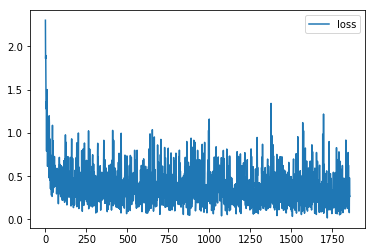

In [11]:
plt.plot(loss_history, label='loss')
plt.legend()
plt.show()

### Test trained model

* test accuracy: 0.9166 for 1 epochs

In [12]:
# test_iterator
test_iterator = test_dataset.make_one_shot_iterator()
test_handle = sess.run(test_iterator.string_handle())

In [13]:
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y, tf.int64))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("test accuracy:", sess.run(accuracy, feed_dict={handle: test_handle}))

test accuracy: 0.9166


### Plot test set

In [14]:
np.random.seed(219)

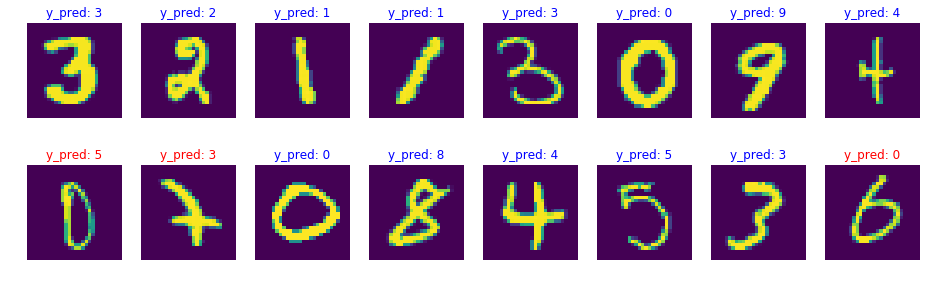

In [15]:
test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)

batch_xs = test_data[batch_index]
batch_ys = test_labels[batch_index]
y_pred_ = sess.run(y_pred, feed_dict={x: batch_xs})

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred_)):
  p = fig.add_subplot(4, 8, i+1)
  if np.argmax(py) == batch_ys[i]:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='blue')
  else:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='red')
  p.imshow(px.reshape(28, 28))
  p.axis('off')

## 직접 실습

* 여러가지 hyper-parameter들을 바꿔가면서 accuracy를 높혀보자